# RNN-sentence classification from spoiler reviews

In [1]:
# install gensim
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /opt/anaconda3/lib/python3.8/site-packages (3.8.3)


In [1]:
# import libraries
import re  # For preprocessing
import pandas as pd  # For data handling
import numpy as np
import json
import gzip
from tqdm import tqdm
from time import time  # To time our operations
from collections import defaultdict  # For word frequency


import spacy  # For preprocessing
import nltk

import gensim
from gensim import corpora, models, similarities, downloader
import gensim.downloader as api

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
# load a pretrained embedding vector model
nlp = api.load("word2vec-google-news-300")

INFO - 22:13:48: loading projection weights from /Users/gregor/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO - 22:15:53: loaded (3000000, 300) matrix from /Users/gregor/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [9]:
#generator to open json.gzip files
# yields single lines
def get_reviews(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l
    f.close()
# fetch features
def fetch_features(file, features):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    file: json.gzip file you want to scan
    features: features to extract from data
    only reviews written in english will be collected
    '''
    
    feature_dict = defaultdict(list)    
    reviews = get_reviews(file)
    
    for review in tqdm(reviews):
        review_dict = json.loads(review)
        language = review_dict.get('review_language_start')
    # for crime only
        genre = review_dict.get('best_genre')
        
        
        if language != 'en': 
            continue
        
        else:
            for f in features:
                feature_dict[f].append(review_dict.get(f))
            
    return pd.DataFrame.from_dict(feature_dict)

In [4]:
# file names
training = 'train_set_text_edit.json.gz'
validation = 'validation_set_text_edit.json.gz'
test = 'test_set_text_edit.json.gz'


In [10]:
# get training data
isolate = ['has_spoiler', 'sentence_labels','lemmatized']

df_train = fetch_features(training, isolate)

964623it [02:58, 5401.64it/s]


In [11]:
df_train.head()

,has_spoiler,sentence_labels,lemmatized
0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[read review blog, , definitely well book, ins..."
1,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[write comment realize probably end long quali...
2,False,"[0, 0, 0, 0]","[charlie turn young sister get marry, decide w..."
3,False,"[0, 0, 0, 0]",[like get implausible storyline read long time...
4,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[review originally post step fiction, want reb..."


In [12]:
# use spoiler reviews only
df_train_spoiler = df_train[df_train['has_spoiler']==True]
df_train_spoiler.head()

INFO - 22:23:46: NumExpr defaulting to 4 threads.


,has_spoiler,sentence_labels,lemmatized
4,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[review originally post step fiction, want reb..."
12,True,"[0, 1, 1, 0]",[interesting volume learn kira power actually ...
26,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[actually surprised enjoy book, completely for..."
32,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",[ok date comment read book go assume eloisa ja...
41,True,[1],[good book series partly fantastic element]


In [13]:
# isolate singel sentences and labels
sentences = []

for review in tqdm(df_train_spoiler['lemmatized']):
    for sentence in review:
        sentences.append(sentence)

labels = []
for review in tqdm(df_train_spoiler['sentence_labels']):
    for label in review:
        labels.append(label)


df_sentences = pd.DataFrame({
    'has_spoiler': labels,
    'sentences': sentences
})

100%|██████████| 58428/58428 [00:00<00:00, 176605.46it/s]


In [14]:
df_sentences.head()

,has_spoiler,sentences
0,0,review originally post step fiction
1,0,want reboot
2,0,sure want low number high number
3,0,lean high number bit kickass
4,0,high number mean long dead reboot


In [15]:
# repeat steps from above for test data

isolate = ['has_spoiler', 'sentence_labels','lemmatized']

df_test = fetch_features(test, isolate)
df_test_spoiler = df_test[df_train['has_spoiler']==True]

sentences_test = []

for review in tqdm(df_test_spoiler['lemmatized']):
    for sentence in review:
        sentences_test.append(sentence)

labels_test = []
for review in tqdm(df_test_spoiler['sentence_labels']):
    for label in review:
        labels_test.append(label)


df_sentences_test = pd.DataFrame({
    'has_spoiler': labels_test,
    'sentences': sentences_test
})

137804it [00:33, 4081.43it/s]
<ipython-input-15-d71c46149917>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_spoiler = df_test[df_train['has_spoiler']==True]
100%|██████████| 8322/8322 [00:00<00:00, 361133.51it/s]


In [16]:
corpus = df_sentences["sentences"]

## create list of lists of unigrams
lst_corpus = []
for string in tqdm(corpus):
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

# detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

100%|██████████| 1385613/1385613 [00:22<00:00, 62450.96it/s] 
INFO - 22:24:53: collecting all words and their counts
INFO - 22:24:53: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 22:24:53: PROGRESS: at sentence #10000, processed 64629 words and 54825 word types
INFO - 22:24:53: PROGRESS: at sentence #20000, processed 127168 words and 97886 word types
INFO - 22:24:53: PROGRESS: at sentence #30000, processed 190643 words and 138704 word types
INFO - 22:24:53: PROGRESS: at sentence #40000, processed 253113 words and 176031 word types
INFO - 22:24:54: PROGRESS: at sentence #50000, processed 316067 words and 211735 word types
INFO - 22:24:54: PROGRESS: at sentence #60000, processed 377891 words and 245558 word types
INFO - 22:24:54: PROGRESS: at sentence #70000, processed 439444 words and 278325 word types
INFO - 22:24:54: PROGRESS: at sentence #80000, processed 502383 words and 311197 word types
INFO - 22:24:54: PROGRESS: at sentence #90000, processed 564922 words an

INFO - 22:25:12: PROGRESS: at sentence #860000, processed 5388334 words and 2073289 word types
INFO - 22:25:13: PROGRESS: at sentence #870000, processed 5451427 words and 2091828 word types
INFO - 22:25:13: PROGRESS: at sentence #880000, processed 5513871 words and 2110227 word types
INFO - 22:25:13: PROGRESS: at sentence #890000, processed 5576820 words and 2129060 word types
INFO - 22:25:13: PROGRESS: at sentence #900000, processed 5640163 words and 2147709 word types
INFO - 22:25:14: PROGRESS: at sentence #910000, processed 5702257 words and 2165502 word types
INFO - 22:25:14: PROGRESS: at sentence #920000, processed 5768074 words and 2184862 word types
INFO - 22:25:14: PROGRESS: at sentence #930000, processed 5830180 words and 2203105 word types
INFO - 22:25:14: PROGRESS: at sentence #940000, processed 5893274 words and 2221047 word types
INFO - 22:25:14: PROGRESS: at sentence #950000, processed 5956220 words and 2239356 word types
INFO - 22:25:15: PROGRESS: at sentence #960000, pr

INFO - 22:26:28: PROGRESS: at sentence #300000, processed 1776152 words and 960229 word types
INFO - 22:26:28: PROGRESS: at sentence #310000, processed 1835000 words and 986034 word types
INFO - 22:26:29: PROGRESS: at sentence #320000, processed 1893893 words and 1011399 word types
INFO - 22:26:29: PROGRESS: at sentence #330000, processed 1951829 words and 1036307 word types
INFO - 22:26:30: PROGRESS: at sentence #340000, processed 2009353 words and 1061041 word types
INFO - 22:26:30: PROGRESS: at sentence #350000, processed 2069464 words and 1087193 word types
INFO - 22:26:31: PROGRESS: at sentence #360000, processed 2128393 words and 1112105 word types
INFO - 22:26:31: PROGRESS: at sentence #370000, processed 2187047 words and 1136481 word types
INFO - 22:26:32: PROGRESS: at sentence #380000, processed 2245910 words and 1160995 word types
INFO - 22:26:32: PROGRESS: at sentence #390000, processed 2306046 words and 1186502 word types
INFO - 22:26:33: PROGRESS: at sentence #400000, proc

INFO - 22:27:11: PROGRESS: at sentence #1170000, processed 6903676 words and 2837471 word types
INFO - 22:27:11: PROGRESS: at sentence #1180000, processed 6961940 words and 2855972 word types
INFO - 22:27:12: PROGRESS: at sentence #1190000, processed 7020281 words and 2874526 word types
INFO - 22:27:13: PROGRESS: at sentence #1200000, processed 7078212 words and 2892755 word types
INFO - 22:27:13: PROGRESS: at sentence #1210000, processed 7138113 words and 2912099 word types
INFO - 22:27:14: PROGRESS: at sentence #1220000, processed 7196612 words and 2930638 word types
INFO - 22:27:14: PROGRESS: at sentence #1230000, processed 7255072 words and 2948207 word types
INFO - 22:27:15: PROGRESS: at sentence #1240000, processed 7315175 words and 2967483 word types
INFO - 22:27:15: PROGRESS: at sentence #1250000, processed 7373613 words and 2985862 word types
INFO - 22:27:15: PROGRESS: at sentence #1260000, processed 7433283 words and 3004838 word types
INFO - 22:27:16: PROGRESS: at sentence #

In [17]:
# fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size = 300, window = 8, min_count = 1, sg = 1, iter =10)

INFO - 22:28:23: collecting all words and their counts
INFO - 22:28:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:28:23: PROGRESS: at sentence #10000, processed 64629 words, keeping 8623 word types
INFO - 22:28:23: PROGRESS: at sentence #20000, processed 127168 words, keeping 12116 word types
INFO - 22:28:23: PROGRESS: at sentence #30000, processed 190643 words, keeping 14918 word types
INFO - 22:28:23: PROGRESS: at sentence #40000, processed 253113 words, keeping 16929 word types
INFO - 22:28:23: PROGRESS: at sentence #50000, processed 316067 words, keeping 18656 word types
INFO - 22:28:23: PROGRESS: at sentence #60000, processed 377891 words, keeping 20171 word types
INFO - 22:28:23: PROGRESS: at sentence #70000, processed 439444 words, keeping 21417 word types
INFO - 22:28:23: PROGRESS: at sentence #80000, processed 502383 words, keeping 22546 word types
INFO - 22:28:23: PROGRESS: at sentence #90000, processed 564922 words, keeping 23584 word types


INFO - 22:28:25: PROGRESS: at sentence #840000, processed 5262976 words, keeping 50153 word types
INFO - 22:28:25: PROGRESS: at sentence #850000, processed 5325885 words, keeping 50347 word types
INFO - 22:28:25: PROGRESS: at sentence #860000, processed 5388334 words, keeping 50527 word types
INFO - 22:28:25: PROGRESS: at sentence #870000, processed 5451427 words, keeping 50701 word types
INFO - 22:28:25: PROGRESS: at sentence #880000, processed 5513871 words, keeping 50887 word types
INFO - 22:28:25: PROGRESS: at sentence #890000, processed 5576820 words, keeping 51047 word types
INFO - 22:28:25: PROGRESS: at sentence #900000, processed 5640163 words, keeping 51194 word types
INFO - 22:28:25: PROGRESS: at sentence #910000, processed 5702257 words, keeping 51353 word types
INFO - 22:28:25: PROGRESS: at sentence #920000, processed 5768074 words, keeping 51544 word types
INFO - 22:28:26: PROGRESS: at sentence #930000, processed 5830180 words, keeping 51701 word types
INFO - 22:28:26: PRO

INFO - 22:29:15: EPOCH 1 - PROGRESS: at 36.18% examples, 125177 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:16: EPOCH 1 - PROGRESS: at 38.14% examples, 126173 words/s, in_qsize 6, out_qsize 0
INFO - 22:29:17: EPOCH 1 - PROGRESS: at 40.25% examples, 127444 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:18: EPOCH 1 - PROGRESS: at 41.43% examples, 125378 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:19: EPOCH 1 - PROGRESS: at 42.58% examples, 123997 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:20: EPOCH 1 - PROGRESS: at 44.16% examples, 123878 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:22: EPOCH 1 - PROGRESS: at 45.66% examples, 123188 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:23: EPOCH 1 - PROGRESS: at 47.27% examples, 123057 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:24: EPOCH 1 - PROGRESS: at 48.44% examples, 121726 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:25: EPOCH 1 - PROGRESS: at 50.14% examples, 122149 words/s, in_qsize 5, out_qsize 0
INFO - 22:29:26: EPOCH 1 - PRO

INFO - 22:30:40: EPOCH 2 - PROGRESS: at 68.81% examples, 123687 words/s, in_qsize 6, out_qsize 0
INFO - 22:30:41: EPOCH 2 - PROGRESS: at 70.84% examples, 124336 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:42: EPOCH 2 - PROGRESS: at 72.68% examples, 124635 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:44: EPOCH 2 - PROGRESS: at 74.07% examples, 124134 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:45: EPOCH 2 - PROGRESS: at 75.68% examples, 124157 words/s, in_qsize 6, out_qsize 0
INFO - 22:30:46: EPOCH 2 - PROGRESS: at 77.40% examples, 124242 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:47: EPOCH 2 - PROGRESS: at 79.13% examples, 124463 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:48: EPOCH 2 - PROGRESS: at 80.66% examples, 124110 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:49: EPOCH 2 - PROGRESS: at 82.04% examples, 123750 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:50: EPOCH 2 - PROGRESS: at 83.09% examples, 122395 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:51: EPOCH 2 - PRO

INFO - 22:32:13: EPOCH 3 - PROGRESS: at 49.46% examples, 62061 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:14: EPOCH 3 - PROGRESS: at 50.24% examples, 62027 words/s, in_qsize 6, out_qsize 0
INFO - 22:32:15: EPOCH 3 - PROGRESS: at 51.17% examples, 62109 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:16: EPOCH 3 - PROGRESS: at 51.86% examples, 61894 words/s, in_qsize 6, out_qsize 0
INFO - 22:32:17: EPOCH 3 - PROGRESS: at 52.54% examples, 61671 words/s, in_qsize 6, out_qsize 0
INFO - 22:32:19: EPOCH 3 - PROGRESS: at 53.25% examples, 61433 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:20: EPOCH 3 - PROGRESS: at 53.95% examples, 61277 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:21: EPOCH 3 - PROGRESS: at 54.65% examples, 61087 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:22: EPOCH 3 - PROGRESS: at 55.11% examples, 60508 words/s, in_qsize 4, out_qsize 1
INFO - 22:32:23: EPOCH 3 - PROGRESS: at 55.71% examples, 60258 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:24: EPOCH 3 - PROGRESS: at 

INFO - 22:33:48: EPOCH 4 - PROGRESS: at 14.24% examples, 51966 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:49: EPOCH 4 - PROGRESS: at 15.03% examples, 52445 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:50: EPOCH 4 - PROGRESS: at 15.85% examples, 52695 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:51: EPOCH 4 - PROGRESS: at 16.53% examples, 52683 words/s, in_qsize 6, out_qsize 0
INFO - 22:33:52: EPOCH 4 - PROGRESS: at 17.35% examples, 52869 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:53: EPOCH 4 - PROGRESS: at 18.14% examples, 53164 words/s, in_qsize 6, out_qsize 0
INFO - 22:33:54: EPOCH 4 - PROGRESS: at 19.06% examples, 53523 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:55: EPOCH 4 - PROGRESS: at 19.86% examples, 53574 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:56: EPOCH 4 - PROGRESS: at 20.54% examples, 53378 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:57: EPOCH 4 - PROGRESS: at 21.43% examples, 53822 words/s, in_qsize 6, out_qsize 0
INFO - 22:33:59: EPOCH 4 - PROGRESS: at 

INFO - 22:35:26: EPOCH 4 - PROGRESS: at 82.73% examples, 54211 words/s, in_qsize 6, out_qsize 0
INFO - 22:35:27: EPOCH 4 - PROGRESS: at 83.43% examples, 54119 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:29: EPOCH 4 - PROGRESS: at 84.11% examples, 53985 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:30: EPOCH 4 - PROGRESS: at 84.82% examples, 53963 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:31: EPOCH 4 - PROGRESS: at 85.39% examples, 53880 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:32: EPOCH 4 - PROGRESS: at 86.09% examples, 53879 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:33: EPOCH 4 - PROGRESS: at 86.68% examples, 53805 words/s, in_qsize 6, out_qsize 0
INFO - 22:35:34: EPOCH 4 - PROGRESS: at 87.35% examples, 53722 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:35: EPOCH 4 - PROGRESS: at 88.04% examples, 53709 words/s, in_qsize 6, out_qsize 0
INFO - 22:35:36: EPOCH 4 - PROGRESS: at 88.74% examples, 53672 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:37: EPOCH 4 - PROGRESS: at 

INFO - 22:37:01: EPOCH 5 - PROGRESS: at 41.31% examples, 49410 words/s, in_qsize 6, out_qsize 0
INFO - 22:37:02: EPOCH 5 - PROGRESS: at 42.00% examples, 49284 words/s, in_qsize 5, out_qsize 0
INFO - 22:37:04: EPOCH 5 - PROGRESS: at 42.69% examples, 49065 words/s, in_qsize 5, out_qsize 0
INFO - 22:37:05: EPOCH 5 - PROGRESS: at 43.36% examples, 48970 words/s, in_qsize 6, out_qsize 0
INFO - 22:37:06: EPOCH 5 - PROGRESS: at 44.04% examples, 48777 words/s, in_qsize 6, out_qsize 0
INFO - 22:37:07: EPOCH 5 - PROGRESS: at 44.61% examples, 48719 words/s, in_qsize 6, out_qsize 0
INFO - 22:37:08: EPOCH 5 - PROGRESS: at 45.08% examples, 48433 words/s, in_qsize 5, out_qsize 0
INFO - 22:37:10: EPOCH 5 - PROGRESS: at 45.90% examples, 48555 words/s, in_qsize 6, out_qsize 0
INFO - 22:37:11: EPOCH 5 - PROGRESS: at 46.58% examples, 48520 words/s, in_qsize 6, out_qsize 1
INFO - 22:37:12: EPOCH 5 - PROGRESS: at 47.27% examples, 48501 words/s, in_qsize 5, out_qsize 0
INFO - 22:37:13: EPOCH 5 - PROGRESS: at 

INFO - 22:38:35: EPOCH 6 - PROGRESS: at 3.90% examples, 51138 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:37: EPOCH 6 - PROGRESS: at 4.95% examples, 51806 words/s, in_qsize 6, out_qsize 0
INFO - 22:38:38: EPOCH 6 - PROGRESS: at 5.98% examples, 52820 words/s, in_qsize 6, out_qsize 0
INFO - 22:38:39: EPOCH 6 - PROGRESS: at 6.66% examples, 52843 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:41: EPOCH 6 - PROGRESS: at 7.33% examples, 51425 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:42: EPOCH 6 - PROGRESS: at 7.67% examples, 49430 words/s, in_qsize 6, out_qsize 0
INFO - 22:38:43: EPOCH 6 - PROGRESS: at 8.37% examples, 47065 words/s, in_qsize 6, out_qsize 1
INFO - 22:38:45: EPOCH 6 - PROGRESS: at 9.06% examples, 46840 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:46: EPOCH 6 - PROGRESS: at 9.75% examples, 45899 words/s, in_qsize 4, out_qsize 1
INFO - 22:38:47: EPOCH 6 - PROGRESS: at 10.43% examples, 45344 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:49: EPOCH 6 - PROGRESS: at 11.13% ex

INFO - 22:40:14: EPOCH 6 - PROGRESS: at 78.56% examples, 58841 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:15: EPOCH 6 - PROGRESS: at 79.72% examples, 59109 words/s, in_qsize 6, out_qsize 0
INFO - 22:40:17: EPOCH 6 - PROGRESS: at 80.66% examples, 59085 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:18: EPOCH 6 - PROGRESS: at 81.71% examples, 59225 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:19: EPOCH 6 - PROGRESS: at 82.16% examples, 58952 words/s, in_qsize 6, out_qsize 1
INFO - 22:40:20: EPOCH 6 - PROGRESS: at 83.09% examples, 59020 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:21: EPOCH 6 - PROGRESS: at 84.11% examples, 59207 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:22: EPOCH 6 - PROGRESS: at 85.39% examples, 59560 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:23: EPOCH 6 - PROGRESS: at 86.56% examples, 59727 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:24: EPOCH 6 - PROGRESS: at 87.81% examples, 60072 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:25: EPOCH 6 - PROGRESS: at 

INFO - 22:41:45: EPOCH 7 - PROGRESS: at 68.34% examples, 77768 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:46: EPOCH 7 - PROGRESS: at 69.37% examples, 77792 words/s, in_qsize 6, out_qsize 0
INFO - 22:41:47: EPOCH 7 - PROGRESS: at 70.04% examples, 77274 words/s, in_qsize 6, out_qsize 0
INFO - 22:41:48: EPOCH 7 - PROGRESS: at 71.31% examples, 77434 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:49: EPOCH 7 - PROGRESS: at 72.46% examples, 77574 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:50: EPOCH 7 - PROGRESS: at 73.61% examples, 77745 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:51: EPOCH 7 - PROGRESS: at 74.77% examples, 77836 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:52: EPOCH 7 - PROGRESS: at 75.92% examples, 78000 words/s, in_qsize 6, out_qsize 0
INFO - 22:41:53: EPOCH 7 - PROGRESS: at 77.07% examples, 78125 words/s, in_qsize 6, out_qsize 0
INFO - 22:41:54: EPOCH 7 - PROGRESS: at 78.20% examples, 78254 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:55: EPOCH 7 - PROGRESS: at 

INFO - 22:43:07: EPOCH 9 - PROGRESS: at 46.13% examples, 235885 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:08: EPOCH 9 - PROGRESS: at 49.23% examples, 236366 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:09: EPOCH 9 - PROGRESS: at 52.21% examples, 235747 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:10: EPOCH 9 - PROGRESS: at 55.36% examples, 236165 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:11: EPOCH 9 - PROGRESS: at 58.45% examples, 236538 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:12: EPOCH 9 - PROGRESS: at 61.59% examples, 236371 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:13: EPOCH 9 - PROGRESS: at 64.69% examples, 236528 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:14: EPOCH 9 - PROGRESS: at 67.77% examples, 236448 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:15: EPOCH 9 - PROGRESS: at 70.39% examples, 235105 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:16: EPOCH 9 - PROGRESS: at 71.99% examples, 230427 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:17: EPOCH 9 - PRO

In [18]:
# max sentence length
df_sentences['length'] = df_sentences['sentences'].apply(lambda x: len(x.split()))
df_sentences['length'].describe()

count    1.385613e+06
mean     6.269136e+00
std      4.712645e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      8.500000e+01
Name: length, dtype: float64

The max length of sentences is 85. however, we wil use 20 as most sentences are even shorter than that (q75 = 9).

In [19]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=20, padding="post", truncating="post")

In [20]:
# prepare test data
corpus = df_sentences_test["sentences"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=20,padding="post", truncating="post")


In [21]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

<ipython-input-21-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]


In [22]:
# built network 
from tensorflow.keras import regularizers
from tensorflow.keras import metrics

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(20,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=20, trainable=True)(x_in)
## apply attention
x = attention_layer(x, neurons=20)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)#
x =layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x =layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x =layers.Dropout(0.5)(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      17325900    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 20)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 20)      420         permute[0][0]                    
_______________________________________________________________________________________

In [24]:
y_train = df_sentences['has_spoiler'].values
y_test = df_sentences_test['has_spoiler'].values

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train

# fit model
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=10, 
                     validation_split=0.25)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


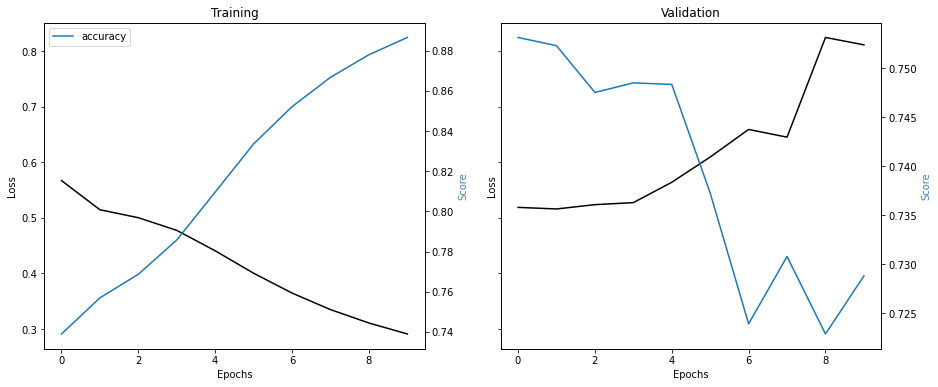

In [25]:
# plot loss and metrics fo rtrain and validation data
import matplotlib.pyplot as plt


metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (15,6))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [27]:
# test on test set
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91    100856
           1       0.08      0.34      0.12      3479

    accuracy                           0.84    104335
   macro avg       0.52      0.60      0.52    104335
weighted avg       0.94      0.84      0.89    104335



In [29]:
confusion_matrix(y_test, predicted)

array([[86646, 14210],
       [ 2312,  1167]])

On the plus side we got it to work but with a recall of 0.34 the model is not very good. 